# Clasificación según distribución de $PM_{2.5}/PM_{10}$

En este código se realiza la clasificación de los datos según la distribución de $PM_{2.5}/PM_{10}$, clasificación propuesta en el artículo de [Fan, H., Zhao, C., Yang, Y., & Yang, X. (2021)](https://doi.org/10.3389/fenvs.2021.692440). Para esto, se utilizarán los datos de las estaciones de monitoreo de Bogotá del año 2022. De estos se hallará el valor del pico, la kurtosis y la asimetría de la distribución de $PM_{2.5}/PM_{10}$ para cada estación. La clasificación se realizará según los siguientes criterios:  
![Clasificación de los contaminantes](../img/clasificacion_pm_ratio.jpg) 

In [1]:
# importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from mpl_toolkits.basemap import Basemap
from datetime import timedelta
import bs4 as bs
import requests
import re

## 1. Importación de datos

In [2]:
# array con los nombres de las estaciones
estaciones = ["BOL","CBV","CDAR","COL","CSE","FTB",
              "GYR","JAZ","KEN","LFR","MAM","MOV1",
              "MOV2","PTE","SCR","SUB","TUN","USM","USQ"]


# importamos los datos de las estaciones y cada DataFrame lo guardamos en un diccionario
datos = {}
for i in estaciones:
    # importamos un set de datos
    data = pd.read_excel(
        "../data/" + str(i) + "_2022.xlsx", skiprows=3, skipfooter=11, index_col=0
    )[["PM10", "PM2.5"]]

    # eliminamos la fila de unidades
    data.drop(data.index[0], inplace=True)

    # cambiamos el indice a tipo fecha, cambiando el 24:00 por 00:00 del otro día
    data.index = pd.to_datetime(
        data.index.str.replace("24:00", "00:00"), format="%d-%m-%Y %H:%M"
    )
    new_index = []
    for j in range(len(data.index)):
        new_index.append(data.index[j])
        if data.index[j].hour == 0:  # si la hora es 00:00 le sumamos un día
            new_index[j] = data.index[j] + timedelta(days=1)
    data.index = new_index

    # cambiamos el tipo de datos a float
    data["PM10"] = pd.to_numeric(data["PM10"], errors="coerce")
    data["PM2.5"] = pd.to_numeric(data["PM2.5"], errors="coerce")

    # eliminamos los datos nulos
    data.dropna(inplace=True)

    # creamos la columna con la relacion PM2.5/PM10
    data["ratio"] = data["PM2.5"] / data["PM10"]

    # guardamos el DataFrame con su nombre en el diccionario
    datos[i] = data

    # eliminamos todas las entradas en las que el ratio es mayor o igual a 1 y menor o igual a 0
    datos[i] = datos[i][datos[i]["ratio"] < 1]
    datos[i] = datos[i][datos[i]["ratio"] > 0]

# calculamos el procentaje de datos que tenemos en cada estacion: datos validos/8600 (8600 horas en un año)
porcentaje_datos = {}
for i in estaciones:
    porcentaje_datos[i] = len(datos[i]) / 8760

# descartamos las estaciones que tienen menos del 70% de datos validos
estaciones = [i for i in estaciones if porcentaje_datos[i] >= 0.7]
datos = {i: datos[i] for i in estaciones}


In [8]:
print("Estaciones con más del 70% de datos validos:")
for i, estacion in enumerate(estaciones):
    print(f"{i+1}. {estacion} - {porcentaje_datos[estacion]*100:.2f}%")

Estaciones con más del 70% de datos validos:
1. BOL - 84.37%
2. CBV - 92.28%
3. CDAR - 81.91%
4. COL - 88.07%
5. FTB - 94.24%
6. GYR - 91.11%
7. JAZ - 93.38%
8. KEN - 83.42%
9. LFR - 84.32%
10. MAM - 75.02%
11. MOV2 - 92.98%
12. SCR - 79.54%
13. SUB - 74.37%
14. TUN - 88.13%
15. USM - 92.55%
16. USQ - 74.26%


## 2. Clasificación de contaminantes en cada estación

Text(0.02, 0.5, 'Frecuencia')

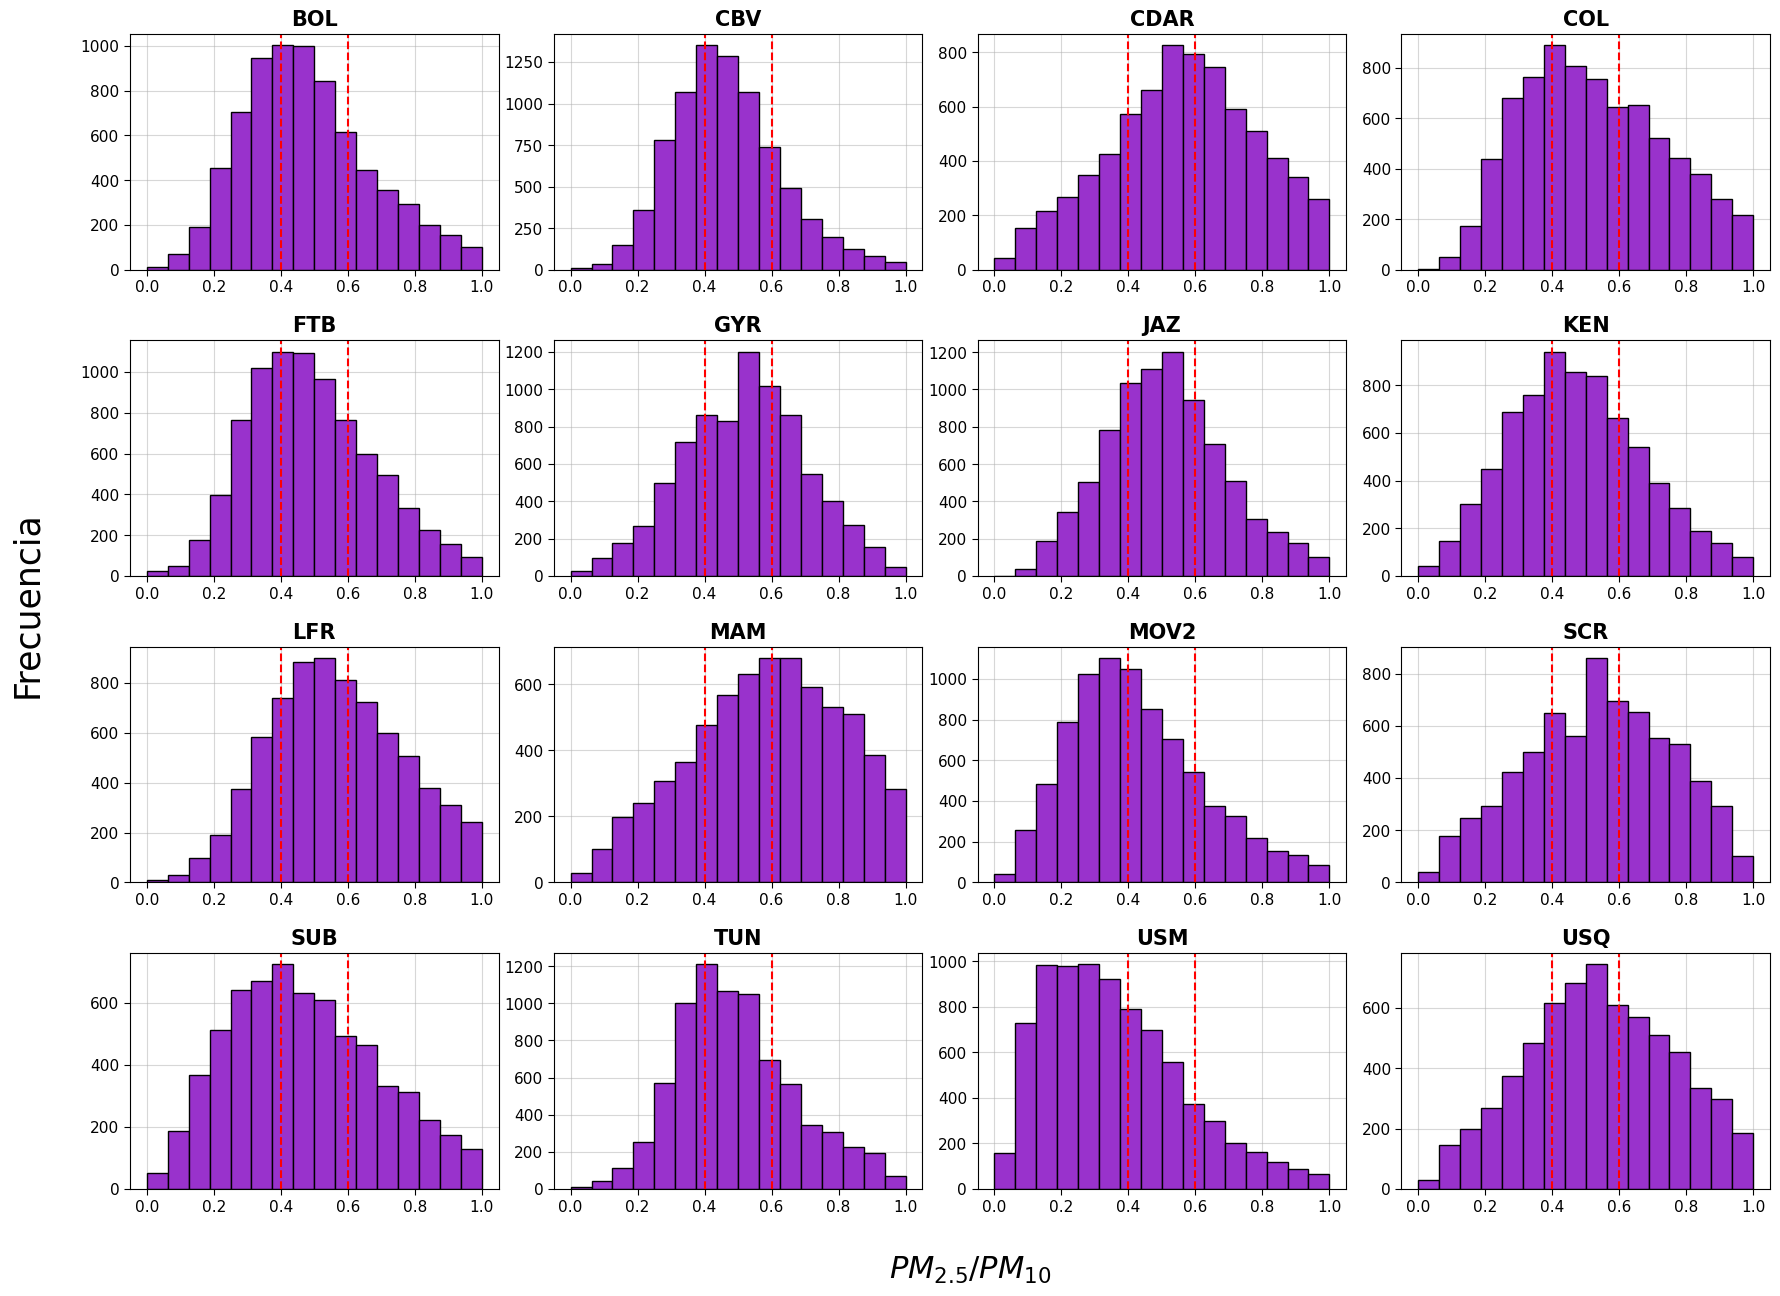

In [3]:
# definimos los limites de los tipos
lim_inf = 0.4
lim_sup = 0.6

# definimos la cantidad de bins
n_bins = 16

# graficamos el histograma de la relacion PM2.5/PM10 para cada estacion
fig, ax = plt.subplots(4, 4, figsize=(20, 15))
ax = ax.ravel()  # convertimos el array de 4x4 a 1x16

for i in range(len(estaciones)):
    ax[i].hist(
        datos[estaciones[i]]["ratio"],
        bins=n_bins,
        edgecolor="black",
        histtype="bar",
        color="darkorchid",
        align="mid",
        range=(0, 1),
    )
    ax[i].axvline(lim_inf, color="red", linestyle="dashed")
    ax[i].axvline(lim_sup, color="red", linestyle="dashed")
    ax[i].set_title(estaciones[i], fontsize=15, fontweight="bold")
    ax[i].grid(alpha=0.5)
    ax[i].set_axisbelow(True)  # para que la grilla quede detras de las barras
    ax[i].tick_params(
        axis="both", which="major", labelsize=11, length=4
    )  # tamaño de los numeros en los ejes

# agregamos espacio entre los subplots
fig.subplots_adjust(hspace=0.3, wspace=0.15, left=0.08)

# agregamos un solo texto centrado en la parte inferior
fig.text(0.5, 0.05, r"$PM_{2.5}/PM_{10}$", ha="center", fontsize=22)

# agregamos un solo texto centrado verticalmente en la parte izquierda
fig.text(0.02, 0.5, "Frecuencia", va="center", rotation="vertical", fontsize=25)

In [4]:
# definimos la función de clasificación
tipos = {
    1.1: "Typical Dust type (Ia)",
    1.2: "Atypical Dust type (Ib)",
    2.1: "Typical Mixed type (IIa)",
    2.21: "Mixed-Anthropogenic type (IIb1)",
    2.22: "Mixed-Dust type (IIb2)",
    3.1: "Typical Anthropogenic type (IIIa)",
    3.2: "Atypical Anthropogenic type (IIIb)",
}


def clasificacion(parametros):
    if parametros[0] <= lim_inf:
        if parametros[1] >= 0:
            return 1.1
        elif parametros[1] < 0:
            return 1.2
    elif parametros[0] > lim_inf and parametros[0] < lim_sup:
        if parametros[1] >= 0:
            return 2.1
        elif parametros[1] < 0:
            if parametros[2] >= 0:
                return 2.21
            elif parametros[2] < 0:
                return 2.22
    elif parametros[0] >= lim_sup:
        if parametros[1] >= 0:
            return 3.1
        elif parametros[1] < 0:
            return 3.2


# calculamos los parametros necesarios para la clasificacion
parametros = {}
for i in estaciones:
    hist, bin_edges = np.histogram(datos[i]["ratio"], bins=n_bins, range=(0, 1))
    peak = bin_edges[np.argmax(hist)]
    kurtosis = datos[i]["ratio"].kurtosis()
    skewness = datos[i]["ratio"].skew()
    parametros[i] = [peak, kurtosis, skewness]

# clasificamos las estaciones
clasificaciones = {}
for i in estaciones:
    clasificaciones[i] = clasificacion(parametros[i])

# imprimimos las clasificaciones
print("Clasificaciones:")
for i in estaciones:
    print(f"{i}: {tipos[clasificaciones[i]]}")

Clasificaciones:
BOL: Atypical Dust type (Ib)
CBV: Typical Dust type (Ia)
CDAR: Mixed-Dust type (IIb2)
COL: Atypical Dust type (Ib)
FTB: Atypical Dust type (Ib)
GYR: Mixed-Dust type (IIb2)
JAZ: Mixed-Anthropogenic type (IIb1)
KEN: Atypical Dust type (Ib)
LFR: Mixed-Anthropogenic type (IIb1)
MAM: Mixed-Dust type (IIb2)
MOV2: Atypical Dust type (Ib)
SCR: Mixed-Dust type (IIb2)
SUB: Atypical Dust type (Ib)
TUN: Atypical Dust type (Ib)
USM: Typical Dust type (Ia)
USQ: Mixed-Dust type (IIb2)


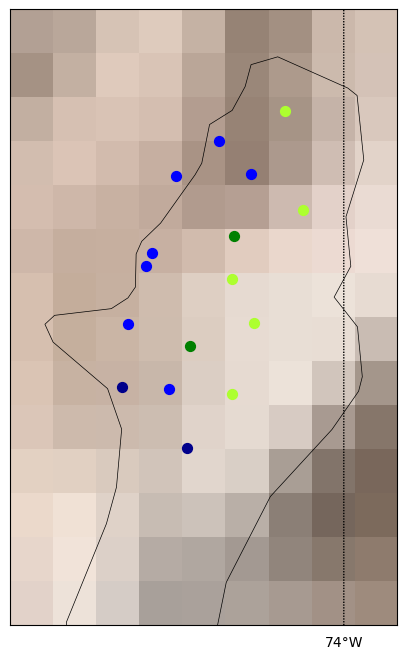

In [5]:
# obtenemos la longitud y latitud de cada estacion desde el sitio web de la secretaria de ambiente de bogota
soup = bs.BeautifulSoup(
    requests.get("https://ambientebogota.gov.co/estaciones-rmcab").text, "html.parser"
)
coordenadas = {}  # diccionario con las coordenadas de cada estacion [latitud, longitud]
for i in estaciones:
    coordenadas[i] = [
        soup.find("td", string=i).find_next_sibling().text.replace(" ", ""),
        soup.find("td", string=i).find_next_sibling().find_next_sibling().text.replace(" ", ""),
    ]

# convertimos las coordenadas a float
def convertir_coordenada(coordenada):
    grados, minutos, segundos, direccion = re.split("[°'\"]", coordenada)
    decimal = float(grados) + float(minutos) / 60 + float(segundos) / 3600
    if direccion in ["S", "W"]:
        decimal *= -1
    return decimal

for i in estaciones:
    coordenadas[i][0] = convertir_coordenada(coordenadas[i][0])
    coordenadas[i][1] = convertir_coordenada(coordenadas[i][1])

# definimos los colores para cada tipo de clasificacion
colores = {
    1.1: "darkblue",
    1.2: "blue",
    2.1: "darkgreen",
    2.21: "green",
    2.22: "greenyellow",
    3.1: "darkred",
    3.2: "red",
}

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 8))

# Configurar el mapa de Bogotá
mapa = Basemap(projection='lcc', lat_0=4.6097, lon_0=-74.0817,
               resolution="h", area_thresh=0.1,
               llcrnrlon=-74.25, llcrnrlat=4.4,
               urcrnrlon=-73.96, urcrnrlat=4.86
               )
mapa.etopo(scale=0.5, alpha=0.5)
mapa.shadedrelief()

# Dibujar los límites del mapa
mapa.drawcoastlines()
mapa.drawcountries()
mapa.drawstates()
# mapa.fillcontinents(color='lightgray', zorder=0)

# Dibujar líneas de latitud y longitud
mapa.drawparallels(range(4, 5), labels=[1, 0, 0, 0])
mapa.drawmeridians(range(-75, -73), labels=[0, 0, 0, 1])

# Convertir las coordenadas a las coordenadas del mapa
x, y = mapa(np.array([coordenadas[i][1] for i in estaciones]), np.array([coordenadas[i][0] for i in estaciones]))


# Dibujar los puntos en el mapa
for i, categoria in enumerate(clasificaciones.values()):
    ax.scatter(x[i], y[i], color=colores[categoria], marker='o', s=50)

# Mostrar el gráfico
plt.show()

In [7]:
for i in colores.keys():
    print(f"{tipos[i]}: {colores[i]}")

Typical Dust type (Ia): darkblue
Atypical Dust type (Ib): blue
Typical Mixed type (IIa): darkgreen
Mixed-Anthropogenic type (IIb1): green
Mixed-Dust type (IIb2): greenyellow
Typical Anthropogenic type (IIIa): darkred
Atypical Anthropogenic type (IIIb): red


## 3. Correlación entre PM2.5, PM10 y PM2.5/PM10

### Recycle Bin

In [ ]:
# #graficamos un histograma de los datos
# plt.figure(figsize=(10,5))
# plt.hist(data["ratio"], bins=25, edgecolor="black", histtype="bar", color="darkorchid", align= "mid")
# plt.axvline(0.4, color="red", linestyle="dashed")
# plt.axvline(0.6, color="red", linestyle="dashed")
# plt.xlabel("PM2.5/PM10")
# plt.ylabel("Frecuencia")
# plt.title("Histograma de la relación PM2.5/PM10")
# plt.grid(alpha=0.5)
# plt.gca().set_axisbelow(True)
# plt.show()

In [6]:
#graficamos las estaciones en un mapa
fig = go.Figure(go.Scattermapbox(
    mode="markers",
    lon=[coordenadas[i][1] for i in estaciones],
    lat=[coordenadas[i][0] for i in estaciones],
    marker={"size": 10, "color": [colores.get(clasificaciones[i]) for i in estaciones]},
    text=[f"{i}: {tipos[clasificaciones[i]]}" for i in estaciones],
))

fig.update_layout(
    title="Clasificación de contaminantes en Bogotá",
    mapbox={
        "style": "carto-positron",
        'center': {'lon': -74.0820, 'lat': 4.7110}, # centro de bogota
        "zoom": 9.5,
    },
    margin={"l": 0, "r": 0, "t": 0, "b": 0}
)

fig.show()